# San Francisco Crime prediction 
# Based on 2 layer neural net and count featurizer

In [68]:
import os
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV
import matplotlib.pylab as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.metrics import log_loss
from sklearn.metrics import make_scorer
from sklearn.cross_validation import StratifiedShuffleSplit
from matplotlib.colors import LogNorm
from sklearn.decomposition import PCA
from keras.layers.advanced_activations import PReLU
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential
from keras.utils import np_utils
from copy import deepcopy

import accelerate
import mkl

%matplotlib inline  

Import data

In [2]:
data_path = "data"
submissions_path = "submissions"

In [3]:
trainDF=pd.read_csv(os.path.join(data_path, "train.csv"))

Clean up wrong X and Y values (very few of them)

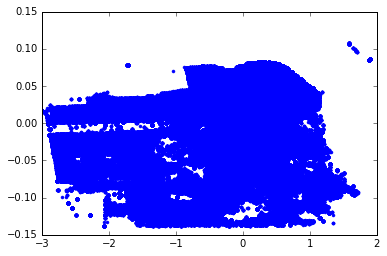

In [4]:
xy_scaler=preprocessing.StandardScaler()
xy_scaler.fit(trainDF[["X","Y"]])
trainDF[["X","Y"]]=xy_scaler.transform(trainDF[["X","Y"]])
trainDF=trainDF[abs(trainDF["Y"])<100]
trainDF.index=range(len(trainDF))
plt.plot(trainDF["X"],trainDF["Y"],'.')
plt.show()

Make plots for each crime label

In [38]:
trainDF.shape

(877982, 9)

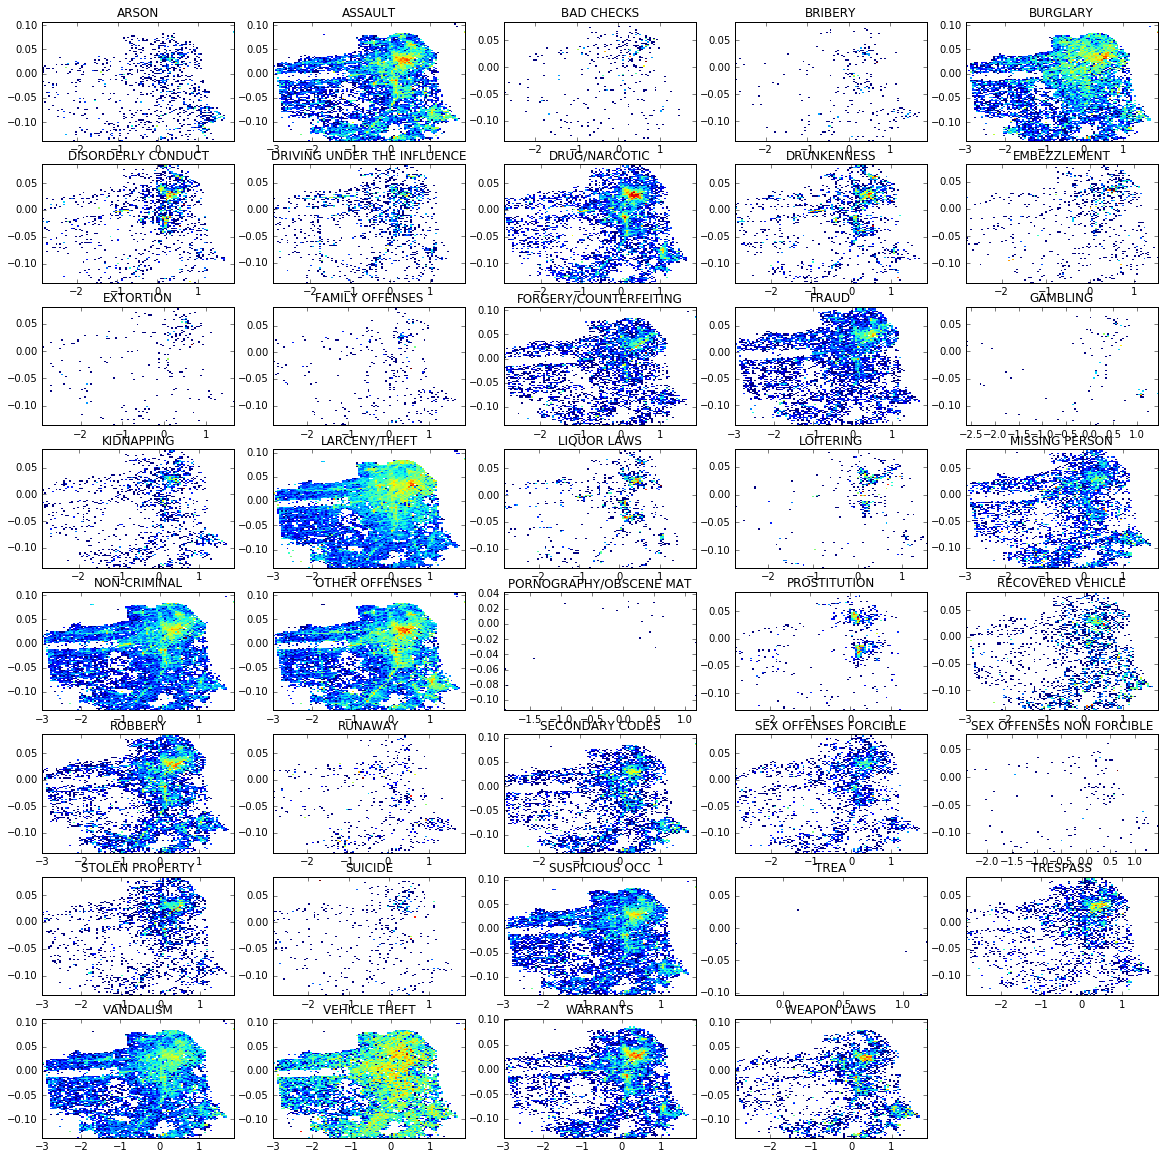

In [5]:
NX=100
NY=100
groups = trainDF.groupby('Category')
ii=1
plt.figure(figsize=(20, 20))
for name, group in groups:
    plt.subplot(8,5,ii)
    histo, xedges, yedges = np.histogram2d(np.array(group.X),np.array(group.Y), bins=(NX,NY))
    myextent  =[xedges[0],xedges[-1],yedges[0],yedges[-1]]
    plt.imshow(histo.T,origin='low',extent=myextent,interpolation='nearest',aspect='auto',norm=LogNorm())
    plt.title(name)
#     plt.figure(ii)
#     plt.plot(group.X,group.Y,'.')
    ii+=1
del groups

# Now proceed as before

In [6]:
def parse_time(x):
    DD=datetime.strptime(x,"%Y-%m-%d %H:%M:%S")
    time=DD.hour#*60+DD.minute
    day=DD.day
    month=DD.month
    year=DD.year
    return time,day,month,year

def get_season(x):
    summer=0
    fall=0
    winter=0
    spring=0
    if (x in [5, 6, 7]):
        summer=1
    if (x in [8, 9, 10]):
        fall=1
    if (x in [11, 0, 1]):
        winter=1
    if (x in [2, 3, 4]):
        spring=1
    return summer, fall, winter, spring

In [7]:
def parse_data(df,logodds,logoddsPA):
    
    feature_list=df.columns.tolist()
    
    if "Descript" in feature_list:
        feature_list.remove("Descript")
    if "Resolution" in feature_list:
        feature_list.remove("Resolution")
    if "Category" in feature_list:
        feature_list.remove("Category")
    if "Id" in feature_list:
        feature_list.remove("Id")
        
    cleanData=df[feature_list]
    cleanData.index=range(len(df))
    
    print "Creating address features"
    address_features=cleanData["Address"].apply(lambda x: logodds[x])
    address_features.columns=["logodds"+str(x) for x in range(len(address_features.columns))]
    
    print "Parsing dates"
    cleanData["Time"], cleanData["Day"], cleanData["Month"], cleanData["Year"]=zip(*cleanData["Dates"].apply(parse_time))
#     dummy_ranks_DAY = pd.get_dummies(cleanData['DayOfWeek'], prefix='DAY')
    days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
#     cleanData["DayOfWeek"]=cleanData["DayOfWeek"].apply(lambda x: days.index(x)/float(len(days)))

    print "Creating one-hot variables"
    dummy_ranks_PD = pd.get_dummies(cleanData['PdDistrict'], prefix='PD')
    dummy_ranks_DAY = pd.get_dummies(cleanData["DayOfWeek"], prefix='DAY')
    
    cleanData["IsInterection"]=cleanData["Address"].apply(lambda x: 1 if "/" in x else 0)
    cleanData["logoddsPA"]=cleanData["Address"].apply(lambda x: logoddsPA[x])
    
    print "droping processed columns"
    cleanData=cleanData.drop("PdDistrict",axis=1)
    cleanData=cleanData.drop("DayOfWeek",axis=1)
    cleanData=cleanData.drop("Address",axis=1)
    cleanData=cleanData.drop("Dates",axis=1)
    feature_list=cleanData.columns.tolist()
    
    print "joining one-hot features"
    features = cleanData[feature_list].join(dummy_ranks_PD.ix[:,:]).join(dummy_ranks_DAY.ix[:,:]).join(address_features.ix[:,:])
    
    print "creating new features"
    features["IsDup"]=pd.Series(features.duplicated()|features.duplicated(take_last=True)).apply(int)
    features["Awake"]=features["Time"].apply(lambda x: 1 if (x==0 or (x>=8 and x<=23)) else 0)
    features["Summer"], features["Fall"], features["Winter"], features["Spring"]=zip(*features["Month"].apply(get_season))
    if "Category" in df.columns:
        labels = df["Category"].astype('category')
#         label_names=labels.unique()
#         labels=labels.cat.rename_categories(range(len(label_names)))
    else:
        labels=None
    return features,labels

This part is slower than it needs to be.

In [8]:
addresses=sorted(trainDF["Address"].unique())
categories=sorted(trainDF["Category"].unique())

C_counts=trainDF.groupby(["Category"]).size()
A_C_counts=trainDF.groupby(["Address","Category"]).size()

A_counts=trainDF.groupby(["Address"]).size()

logodds={}
logoddsPA={}

MIN_CAT_COUNTS=2

default_logodds=np.log(C_counts/len(trainDF))-np.log(1.0-C_counts/float(len(trainDF)))

for addr in addresses:
    PA=A_counts[addr]/float(len(trainDF))
    logoddsPA[addr]=np.log(PA)-np.log(1.-PA)
    logodds[addr]=deepcopy(default_logodds)
    for cat in A_C_counts[addr].keys():
        if (A_C_counts[addr][cat]>MIN_CAT_COUNTS) and A_C_counts[addr][cat]<A_counts[addr]:
            PA=A_C_counts[addr][cat]/float(A_counts[addr])
            logodds[addr][categories.index(cat)]=np.log(PA)-np.log(1.0-PA)
    logodds[addr]=pd.Series(logodds[addr])
    logodds[addr].index=range(len(categories))

In [9]:
features, labels=parse_data(trainDF,logodds,logoddsPA)

Creating address features
Parsing dates


/Users/koza/ipykernel/ipykernel/__main__.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Creating one-hot variables
droping processed columns
joining one-hot features
creating new features


/Users/koza/ipykernel/ipykernel/__main__.py:45: FutureWarning: the take_last=True keyword is deprecated, use keep='last' instead


In [10]:
print features.columns.tolist()
print len(features.columns)

['X', 'Y', 'Time', 'Day', 'Month', 'Year', 'IsInterection', 'logoddsPA', 'PD_BAYVIEW', 'PD_CENTRAL', 'PD_INGLESIDE', 'PD_MISSION', 'PD_NORTHERN', 'PD_PARK', 'PD_RICHMOND', 'PD_SOUTHERN', 'PD_TARAVAL', 'PD_TENDERLOIN', 'DAY_Friday', 'DAY_Monday', 'DAY_Saturday', 'DAY_Sunday', 'DAY_Thursday', 'DAY_Tuesday', 'DAY_Wednesday', 'logodds0', 'logodds1', 'logodds2', 'logodds3', 'logodds4', 'logodds5', 'logodds6', 'logodds7', 'logodds8', 'logodds9', 'logodds10', 'logodds11', 'logodds12', 'logodds13', 'logodds14', 'logodds15', 'logodds16', 'logodds17', 'logodds18', 'logodds19', 'logodds20', 'logodds21', 'logodds22', 'logodds23', 'logodds24', 'logodds25', 'logodds26', 'logodds27', 'logodds28', 'logodds29', 'logodds30', 'logodds31', 'logodds32', 'logodds33', 'logodds34', 'logodds35', 'logodds36', 'logodds37', 'logodds38', 'IsDup', 'Awake', 'Summer', 'Fall', 'Winter', 'Spring']
70


In [81]:
print np.max(features['IsDup'])

1.25782261582


In [12]:
# num_feature_list=["Time","Day","Month","Year","DayOfWeek"]
collist=features.columns.tolist()
scaler = preprocessing.StandardScaler()
scaler.fit(features)
features[collist]=scaler.transform(features)

[ 0.07714363  0.06267647  0.04861061  0.04300871  0.03340587  0.03085896
  0.02834616  0.02731142  0.02509795  0.02393235  0.02272111  0.02029053
  0.02000664  0.019452    0.01918369  0.01820193  0.01729548  0.01724542
  0.01715838  0.01714426  0.01703779  0.01695665  0.01668107  0.01651773
  0.01626539  0.01588035  0.01489293  0.01472615  0.01422875  0.01412131
  0.0136947   0.01330571  0.01234474  0.01181851  0.01158515  0.01126484
  0.01104143  0.0105683   0.01032344  0.00943963  0.00903894  0.00838257
  0.00819149  0.00795652  0.0074206   0.00726109  0.00707183  0.00675531
  0.0067189   0.00646287  0.00634686  0.00612685  0.0060737   0.00556134
  0.00526841  0.00516993  0.0048638   0.00452517  0.00417899  0.00407036]


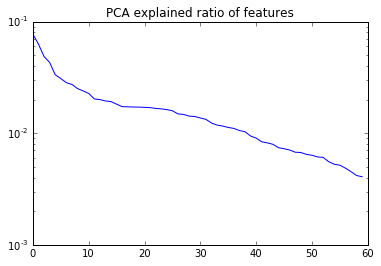

In [13]:
new_PCA=PCA(n_components=60)
new_PCA.fit(features)
plt.plot(new_PCA.explained_variance_ratio_)
plt.yscale('log')
plt.title("PCA explained ratio of features")
print new_PCA.explained_variance_ratio_

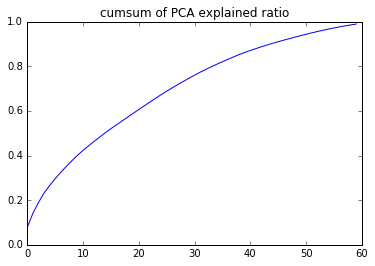

In [14]:
plt.plot(new_PCA.explained_variance_ratio_.cumsum())
plt.title("cumsum of PCA explained ratio")

PCA is interesting, here to play with it more

In [15]:
# features=new_PCA.transform(features)
# features=pd.DataFrame(features)

In [17]:
sss = StratifiedShuffleSplit(labels, train_size=0.5)
for train_index, test_index in sss:
    features_train,features_test=features.iloc[train_index],features.iloc[test_index]
    labels_train,labels_test=labels[train_index],labels[test_index]
features_test.index=range(len(features_test))
features_train.index=range(len(features_train))
labels_train.index=range(len(labels_train))
labels_test.index=range(len(labels_test))
features.index=range(len(features))
labels.index=range(len(labels))

In [49]:
def build_and_fit_model(X_train,y_train,X_test=None,y_test=None,hn=128,dp=0.5,layers=1,epochs=1,batches=64,verbose=0):
    input_dim=X_train.shape[1]
    output_dim=len(labels_train.unique())
    Y_train=y_train.cat.rename_categories(range(len(y_train.unique())))

    model = Sequential()
    model.add(Dense(input_dim=input_dim, output_dim=hn, init='glorot_uniform'))
    model.add(PReLU(input_shape=(hn,)))
    model.add(Dropout(dp))

    for i in range(layers):
        model.add(Dense(input_dim=hn, output_dim=hn,init='glorot_uniform'))
        model.add(PReLU(input_shape=(hn,)))
        model.add(BatchNormalization())
        model.add(Dropout(dp))

    model.add(Dense(input_dim=hn, output_dim=output_dim,init='glorot_uniform'))
    model.add(Activation('softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')
    
    if X_test is not None:
        Y_test=y_test.cat.rename_categories(range(len(y_test.unique())))
        fitting=model.fit(X_train, Y_train, nb_epoch=epochs, batch_size=batches,verbose=verbose,validation_data=(X_test,Y_test))
        test_score = log_loss(y_test, model.predict_proba(X_test,verbose=0))
    else:
        model.fit(X_train, Y_train, nb_epoch=epochs, batch_size=batches,verbose=verbose)
        fitting=0
        test_score = 0
    return test_score, fitting, model

In [36]:
#features.columns.tolist()

#features.head()

20



In [55]:
N_EPOCHS=20
N_HN=256 #39
N_LAYERS=1
DP=0.5

In [56]:
score, fitting, model = build_and_fit_model(features_train.as_matrix(),labels_train,X_test=features_test.as_matrix(),y_test=labels_test,hn=N_HN,layers=N_LAYERS,epochs=N_EPOCHS,verbose=2,dp=DP)

Train on 438991 samples, validate on 438988 samples
Epoch 1/20
44s - loss: 2.3903 - val_loss: 2.2081
Epoch 2/20
45s - loss: 2.2594 - val_loss: 2.2014
Epoch 3/20
45s - loss: 2.2435 - val_loss: 2.1900
Epoch 4/20
45s - loss: 2.2359 - val_loss: 2.1846
Epoch 5/20
45s - loss: 2.2299 - val_loss: 2.1824
Epoch 6/20
45s - loss: 2.2260 - val_loss: 2.1790
Epoch 7/20
45s - loss: 2.2221 - val_loss: 2.1790
Epoch 8/20
45s - loss: 2.2201 - val_loss: 2.1732
Epoch 9/20
45s - loss: 2.2181 - val_loss: 2.1727
Epoch 10/20
45s - loss: 2.2164 - val_loss: 2.1702
Epoch 11/20
44s - loss: 2.2149 - val_loss: 2.1706
Epoch 12/20
45s - loss: 2.2142 - val_loss: 2.1697
Epoch 13/20
45s - loss: 2.2123 - val_loss: 2.1727
Epoch 14/20
45s - loss: 2.2108 - val_loss: 2.1687
Epoch 15/20
45s - loss: 2.2103 - val_loss: 2.1665
Epoch 16/20
45s - loss: 2.2103 - val_loss: 2.1687
Epoch 17/20
44s - loss: 2.2088 - val_loss: 2.1655
Epoch 18/20
45s - loss: 2.2073 - val_loss: 2.1656
Epoch 19/20
45s - loss: 2.2066 - val_loss: 2.1660
Epoch 2

In [57]:
print "all", log_loss(labels, model.predict_proba(features.as_matrix(),verbose=0))
print "train", log_loss(labels_train, model.predict_proba(features_train.as_matrix(),verbose=0))
print "test", log_loss(labels_test, model.predict_proba(features_test.as_matrix(),verbose=0))

all 2.1571274613
train 2.14939318567
test 2.16485780232


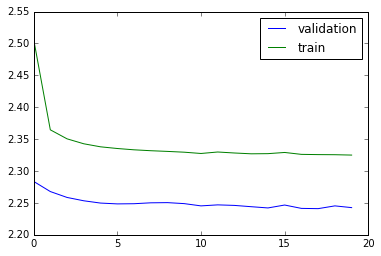

In [23]:
plt.plot(fitting.history['val_loss'],label="validation")
plt.plot(fitting.history['loss'],label="train")
# plt.xscale('log')
plt.legend()

Now train the final model

In [37]:
features.shape

(877982, 70)

In [75]:
score, fitting, model = build_and_fit_model(features.as_matrix(),labels,hn=256,layers=N_LAYERS,epochs=N_EPOCHS,verbose=2,dp=DP)

Epoch 1/20
366s - loss: 2.3378
Epoch 2/20
360s - loss: 2.2112
Epoch 3/20
359s - loss: 2.2001
Epoch 4/20
674s - loss: 2.1949
Epoch 5/20
359s - loss: 2.1903
Epoch 6/20
359s - loss: 2.1875
Epoch 7/20
359s - loss: 2.1847
Epoch 8/20
359s - loss: 2.1821
Epoch 9/20
362s - loss: 2.1802
Epoch 10/20
353s - loss: 2.1783
Epoch 11/20
359s - loss: 2.1762
Epoch 12/20
360s - loss: 2.1751
Epoch 13/20
380s - loss: 2.1737
Epoch 14/20
359s - loss: 2.1721
Epoch 15/20
360s - loss: 2.1713
Epoch 16/20
359s - loss: 2.1700
Epoch 17/20
359s - loss: 2.1685
Epoch 18/20
360s - loss: 2.1674
Epoch 19/20
359s - loss: 2.1668
Epoch 20/20
359s - loss: 2.1653


In [76]:
print "all", log_loss(labels, model.predict_proba(features.as_matrix(),verbose=0))
print "train", log_loss(labels_train, model.predict_proba(features_train.as_matrix(),verbose=0))
print "test", log_loss(labels_test, model.predict_proba(features_test.as_matrix(),verbose=0))

all 2.11730081162
train 2.11665293442
test 2.11794371591


In [60]:
testDF=pd.read_csv(os.path.join(data_path,"test.csv"))
testDF[["X","Y"]]=xy_scaler.transform(testDF[["X","Y"]])
#set outliers to 0
testDF["X"]=testDF["X"].apply(lambda x: 0 if abs(x)>5 else x)
testDF["Y"]=testDF["Y"].apply(lambda y: 0 if abs(y)>5 else y)

In [61]:
new_addresses=sorted(testDF["Address"].unique())
new_A_counts=testDF.groupby("Address").size()
only_new=set(new_addresses+addresses)-set(addresses)
only_old=set(new_addresses+addresses)-set(new_addresses)
in_both=set(new_addresses).intersection(addresses)
for addr in only_new:
    PA=new_A_counts[addr]/float(len(testDF)+len(trainDF))
    logoddsPA[addr]=np.log(PA)-np.log(1.-PA)
    logodds[addr]=deepcopy(default_logodds)
    logodds[addr].index=range(len(categories))
for addr in in_both:
    PA=(A_counts[addr]+new_A_counts[addr])/float(len(testDF)+len(trainDF))
    logoddsPA[addr]=np.log(PA)-np.log(1.-PA)

In [62]:
features_sub, _=parse_data(testDF,logodds,logoddsPA)
# scaler.fit(features_test)

Creating address features
Parsing dates
Creating one-hot variables
droping processed columns
joining one-hot features
creating new features


/Users/koza/ipykernel/ipykernel/__main__.py:45: FutureWarning: the take_last=True keyword is deprecated, use keep='last' instead


In [63]:
collist=features_sub.columns.tolist()
print len(collist)

70


In [64]:
features_sub[collist]=scaler.transform(features_sub[collist])

In [77]:
predDF=pd.DataFrame(model.predict_proba(features_sub.as_matrix(),verbose=0),columns=sorted(labels.unique()))

In [66]:
predDF.head()

,ARSON,ASSAULT,BAD CHECKS,BRIBERY,BURGLARY,DISORDERLY CONDUCT,DRIVING UNDER THE INFLUENCE,DRUG/NARCOTIC,DRUNKENNESS,EMBEZZLEMENT,...,SEX OFFENSES NON FORCIBLE,STOLEN PROPERTY,SUICIDE,SUSPICIOUS OCC,TREA,TRESPASS,VANDALISM,VEHICLE THEFT,WARRANTS,WEAPON LAWS
0,0.007469,0.100266,0.000021,0.000010,0.040440,0.000759,0.000985,0.003872,0.000912,0.000350,...,0.000053,0.000312,0.000423,0.051363,3.452272e-09,0.002917,0.091580,0.143493,0.018152,0.004057
1,0.001988,0.098648,0.000007,0.000029,0.001741,0.000517,0.007147,0.011645,0.001939,0.000036,...,0.000012,0.000631,0.000031,0.035577,3.039490e-09,0.000411,0.053095,0.084798,0.046213,0.008064
2,0.002932,0.021280,0.000017,0.000001,0.137797,0.000288,0.000981,0.000316,0.000122,0.000176,...,0.000005,0.000129,0.000265,0.019115,1.750234e-09,0.000907,0.060120,0.220283,0.002559,0.000628
3,0.001086,0.273553,0.000038,0.001572,0.009785,0.006088,0.003934,0.054223,0.036683,0.000131,...,0.000148,0.008802,0.000343,0.038923,2.624591e-07,0.003225,0.051720,0.008356,0.068101,0.041601
4,0.001086,0.273553,0.000038,0.001572,0.009785,0.006088,0.003934,0.054223,0.036683,0.000131,...,0.000148,0.008802,0.000343,0.038923,2.624591e-07,0.003225,0.051720,0.008356,0.068101,0.041601


In [78]:
predDF.to_csv(os.path.join(submissions_path, "crimeSF_NN_logodds211.csv"),index_label="Id",na_rep="0")

In [47]:
features_sub.head()

,X,Y,Time,Day,Month,Year,IsInterection,logoddsPA,PD_BAYVIEW,PD_CENTRAL,...,logodds35,logodds36,logodds37,logodds38,IsDup,Awake,Summer,Fall,Winter,Spring
0,0.916586,-1.323573,1.463812,-0.634239,-0.418903,1.731591,-0.649964,-0.435686,2.969581,-0.328369,...,0.710170,0.661318,0.615378,-0.194372,-0.795025,0.390475,1.72683,-0.579573,-0.447534,-0.587391
1,1.235548,-1.431939,1.463812,-0.634239,-0.418903,1.731591,1.538547,0.162568,2.969581,-0.328369,...,0.172386,0.371636,1.325077,0.714898,-0.795025,0.390475,1.72683,-0.579573,-0.447534,-0.587391
2,-0.128093,1.041929,1.463812,-0.634239,-0.418903,1.731591,-0.649964,-1.060480,-0.336748,-0.328369,...,0.172386,1.590102,-0.242038,-0.194372,-0.795025,0.390475,1.72683,-0.579573,-0.447534,-0.587391
3,-0.578646,-1.887991,1.463812,-0.634239,-0.418903,1.731591,-0.649964,0.626212,-0.336748,-0.328369,...,0.930020,-0.930320,-0.135443,1.989191,1.257823,0.390475,1.72683,-0.579573,-0.447534,-0.587391
4,-0.578646,-1.887991,1.463812,-0.634239,-0.418903,1.731591,-0.649964,0.626212,-0.336748,-0.328369,...,0.930020,-0.930320,-0.135443,1.989191,1.257823,0.390475,1.72683,-0.579573,-0.447534,-0.587391


In [69]:
classifier = LogisticRegression()
lrmodel = classifier.fit(features_train.as_matrix(),labels_train)
print lrmodel.score(features_test.as_matrix(),labels_test)

0.325434863823


In [70]:
print "LR loss test", log_loss(labels_test, lrmodel.predict_proba(features_test.as_matrix()))
predDF_LR=pd.DataFrame(lrmodel.predict_proba(features_sub.as_matrix()),columns=sorted(labels.unique()))
predDF_LR.to_csv(os.path.join(submissions_path, "crimeSF_LR_logodds22.csv"),index_label="Id",na_rep="0")

LR loss test 2.21949677665


In [73]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier()
rfmodel = classifier.fit(features_train.as_matrix(),labels_train)
print rfmodel.score(features_test.as_matrix(),labels_test)

0.289780130664


In [74]:
print "RF loss test", log_loss(labels_test, rfmodel.predict_proba(features_test.as_matrix()))
predDF_RF=pd.DataFrame(rfmodel.predict_proba(features_sub.as_matrix()),columns=sorted(labels.unique()))
predDF_RF.to_csv(os.path.join(submissions_path, "crimeSF_RF_logodds22.csv"),index_label="Id",na_rep="0")

RF loss test 13.4514020772
